#Problem 2 - Semantic Search for RAG Systems  (30 points)

## Tasks:

1. **(12 points) Document Processing and Vector Store Setup:**
   - Load text documents using appropriate document loaders (e.g., PyPDFLoader for PDFs)
   - Split documents into chunks using `chunk_size` and `chunk_overlap` parameters with `RecursiveCharacterTextSplitter`
   - Generate embeddings for each chunk using a pre-trained embedding model
   - Store the embeddings in a vector database (e.g., Chroma) with proper metadata
   - Demonstrate the setup with sample documents and verify chunk creation

2. **(10 points) Implement Semantic Search with Multiple Methods:**
   - Implement similarity search using `vector_store.similarity_search()` method
   - Implement Maximum Marginal Relevance (MMR) search using `vector_store.max_marginal_relevance_search()` method
   - **MMR Definition:** A retrieval strategy that balances relevance with diversity to reduce redundant results.  
     MMR iteratively selects documents that are both relevant to the query **and** different from already-selected documents.  
     Use the formula:  
    $$MMR = \lambda \times Sim(doc, query) - (1-\lambda) \times \max(Sim(doc, selected))$$

     where \( \lambda = 0.5 \)
   - Demonstrate both search methods with the same queries and compare results
   - Include search with similarity scores using `similarity_search_with_score()`

3. **(8 points) Evaluate your implementation by:**
   - Testing on a provided dataset of 20 short articles about different topics
   - Comparing retrieval quality between different chunk sizes (500, 1000, 1500 characters)
   - Measuring and reporting search latency for different values of k (1, 5, 10)
   - Analyzing the effect of different search types on result diversity (compare similarity vs MMR results for the same query)
   - Demonstrating scenarios where MMR provides better coverage than similarity search
   - Creating visualizations of embedding similarities using dimensionality reduction


### Bonus:
- **(+4 points):** Implement a hybrid search combining semantic search with keyword-based BM25 scoring
- **(+3 points):** Create a simple web interface demonstrating your search engine
- **(+3 points):** Implement and compare different embedding models (e.g., OpenAI, Cohere, local models)


In [3]:
# (run once if needed)
!pip install -q "langchain>=0.2.10" "langchain-openai>=0.2.10" "langchain-community>=0.2.10" "langchain-huggingface>=0.2.10" \
                "langchain-text-splitters>=0.2.0" "chromadb>=0.5.5" \
                "sentence-transformers>=2.2.2" "pypdf>=4.2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 69.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.8/449.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 63.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import langchain
print(f"LangChain version: {langchain.__version__}")

LangChain version: 0.3.27


In [5]:
# Import necessary libraries
import os
from dotenv import load_dotenv
from langchain_openai import OpenAI
from langchain.agents import load_tools, initialize_agent, AgentType
from langchain.tools import Tool
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

# Load environment variables, including both OPENAI_API_KEY and SERPAPI_API_KEY
os.environ['OPENAI_API_KEY'] = 'INSERT OPENAI_API_KEY'
os.environ['SERPAPI_API_KEY'] = 'INSERT SERPAPI_API_KEY'
load_dotenv()

# Initialize the OpenAI language model
llm = OpenAI(temperature=0)

In [46]:
# --- imports & paths ---
import os, glob
from langchain_community.document_loaders import PyPDFLoader
from  langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

DATA_DIR = "../input/documents"      # put your 8–10 docs here (PDF/TXT/MD)
PERSIST_DIR = "./chroma"    # where Chroma DB will be saved
COLLECTION = "rag_demo"
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200

In [13]:
# Collection of 8-10 Wikipedia articles covering different topics (technology, science, sports, politics, history)
ls ../input/documents

History_of_sport.pdf       History.pdf           Politics.pdf  Sport.pdf
History_of_technology.pdf  Machine_learning.pdf  Science.pdf   Technology.pdf


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
# Load text documents using appropriate document loaders (e.g., PyPDFLoader for PDFs)
paths = sorted(
    glob.glob(os.path.join(DATA_DIR, "**/*.pdf"), recursive=True)
  + glob.glob(os.path.join(DATA_DIR, "**/*.txt"), recursive=True)
  + glob.glob(os.path.join(DATA_DIR, "**/*.md"),  recursive=True)
)
docs = []
for p in paths:
    loader = PyPDFLoader(p) if p.lower().endswith(".pdf") else TextLoader(p, encoding="utf-8")
    docs.extend(loader.load())
print(f"Loaded {len(docs)} docs from {len(paths)} files")

Loaded 248 docs from 8 files


In [8]:
# Split documents into chunks using RecursiveCharacterTextSplitter with chunk size and chunk overlap parameters
splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    add_start_index=True,
)
chunks = splitter.split_documents(docs)
print(f"Created {len(chunks)} chunks")

Created 1016 chunks


In [9]:
# Initialize pre-trained embedding model
emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

2025-10-30 15:57:00.016318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761839820.326532      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761839820.429965      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [47]:
# Generate embeddings for each chunk using a pre-trained embedding model
# Store the embeddings in a vector database (e.g., Chroma) with proper metadata to enable cosine distance calculations
vs = Chroma.from_documents(
    documents=chunks,
    embedding=emb,
    persist_directory=PERSIST_DIR,
    collection_name=COLLECTION,
    collection_metadata={"hnsw:space": "cosine"}
)
vs.persist()
print("Persisted at:", os.path.abspath(PERSIST_DIR))
print("Vector count:", vs._collection.count())

Persisted at: /kaggle/working/chroma
Vector count: 1016


In [48]:
# Demonstrate the setup with sample documents and verify chunk creation
sample = vs._collection.get(include=["metadatas"], limit=3)
print("Sample metadatas:", sample.get("metadatas", []))

Sample metadatas: [{'producer': 'Skia/PDF m141', 'page_label': '1', 'moddate': '2025-10-30T15:47:43+00:00', 'total_pages': 47, 'creationdate': '2025-10-30T15:47:43+00:00', 'page': 0, 'source': '../input/documents/History.pdf', 'start_index': 0, 'title': 'History - Wikipedia', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/141.0.0.0 Safari/537.36'}, {'page_label': '1', 'creationdate': '2025-10-30T15:47:43+00:00', 'start_index': 894, 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/141.0.0.0 Safari/537.36', 'total_pages': 47, 'source': '../input/documents/History.pdf', 'moddate': '2025-10-30T15:47:43+00:00', 'producer': 'Skia/PDF m141', 'page': 0, 'title': 'History - Wikipedia'}, {'total_pages': 47, 'producer': 'Skia/PDF m141', 'page_label': '1', 'moddate': '2025-10-30T15:47:43+00:00', 'page': 0, 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChr

In [49]:
total_vectors = vs._collection.count()

# Implement similarity search using vector_store.similarity_search_with_score() method
def vector_store_similarity_search(query, k):
    # Handle edge cases where k exceeds available documents
    k = min(k, total_vectors)
    results = vs.similarity_search_with_score(query=query, k=k)
    return results

# Implement Maximum Marginal Relevance (MMR) search using vector_store.max_marginal_relevance_search() method
def vector_store_max_marginal_relevance_search(query, k): 
    # Handle edge cases where k exceeds available documents
    k = min(k, total_vectors)
    results = vs.max_marginal_relevance_search(query=query, k=k)
    return results

In [58]:
# Demonstrate both search methods with the same queries and compare results
test_queries = ["artificial intelligence applications", "climate change effects", "Olympic games history", "economic policy impacts"]

# Loop through queries
for query in test_queries:
    print("Query: " + query)
    # Get Similarity Search results
    similarity_search_results = vector_store_similarity_search(query, k=3)
    print("Similarity Search with Scores Results")
    for (document, score) in similarity_search_results: 
        # Raw score = cosine distance
        # Cosine similarity = 1 - cosine distance
        cosine_similarity = 1 - score
        print("Document: " + document.metadata["title"] + ", Page: " + str(document.metadata["page"]) + ", Cosine Similarity Score: " + str(cosine_similarity))

    # Get MMR Search results
    mmr_search_results = vector_store_max_marginal_relevance_search(query, k=3)
    print("Max Marginal Relevance Search Results")
    for document in mmr_search_results:
        print("Document: " + document.metadata["title"] + ", Page: " + str(document.metadata["page"]))
    print()
    print()

"""
For the first query("artificial intelligence applications"), both search methods returned the same results(the exact same pages from the machine learning wikipedia article in the exact same order as well). For the second query("climate change effects"), there is more of a difference between the results for the search methods as the results differ more in terms of the pages and overall documents retrieved. It also looks like the max marginal relevance search method produces more diverse results than the regular similarity search method. For the third query("Olympic games history"), the results show the same trend that was seen in the previous query. Also, the max marginal relevance search method still produces similar results in terms of diversity as what was seen in the previous query. For the fouth query("economic policy impacts"), the results for the search methods are more similar than what was seen for queries two and three in terms of the pages and overall documents retrieved. The search methods also seem to basically agree on the most relevant chunk(in terms of the overall document and page retrieved) for each query.
"""

Query: artificial intelligence applications
Similarity Search with Scores Results
Document: Machine learning - Wikipedia, Page: 11, Cosine Similarity Score: 0.5009536743164062
Document: Machine learning - Wikipedia, Page: 14, Cosine Similarity Score: 0.4993807077407837
Document: Machine learning - Wikipedia, Page: 18, Cosine Similarity Score: 0.4594351053237915
Max Marginal Relevance Search Results
Document: Machine learning - Wikipedia, Page: 11
Document: Machine learning - Wikipedia, Page: 14
Document: Machine learning - Wikipedia, Page: 18


Query: climate change effects
Similarity Search with Scores Results
Document: Technology - Wikipedia, Page: 20, Cosine Similarity Score: 0.5481756925582886
Document: Technology - Wikipedia, Page: 20, Cosine Similarity Score: 0.5200040340423584
Document: Science - Wikipedia, Page: 37, Cosine Similarity Score: 0.4506065845489502
Max Marginal Relevance Search Results
Document: Technology - Wikipedia, Page: 20
Document: Machine learning - Wikipedia,

'\nFor the first query("artificial intelligence applications"), both search methods returned the same results(the exact same pages from the machine learning wikipedia article in the exact same order as well). For the second query("climate change effects"), there is more of a difference between the results for the search methods as the results differ more in terms of the pages and overall documents retrieved. It also looks like the max marginal relevance search method produces more diverse results than the regular similarity search method. For the third query("Olympic games history"), the results show the same trend that was seen in the previous query. Also, the max marginal relevance search method still produces similar results in terms of diversity as what was seen in the previous query. For the fouth query("economic policy impacts"), the results for the search methods are more similar than what was seen for queries two and three in terms of the pages and overall documents retrieved. 

Comparison of Results

For the first query("artificial intelligence applications"), both search methods returned the same results(the exact same pages from the machine learning wikipedia article in the exact same order as well). For the second query("climate change effects"), there is more of a difference between the results for the search methods as the results differ more in terms of the pages and overall documents retrieved. It also looks like the max marginal relevance search method produces more diverse results than the regular similarity search method. For the third query("Olympic games history"), the results show the same trend that was seen in the previous query. Also, the max marginal relevance search method still produces similar results in terms of diversity as what was seen in the previous query. For the fouth query("economic policy impacts"), the results for the search methods are more similar than what was seen for queries two and three in terms of the pages and overall documents retrieved. The search methods also seem to basically agree on the most relevant chunk(in terms of the overall document and page retrieved) for each query.

In [59]:
# Comparing retrieval quality between different chunk sizes (500, 1000, 1500 characters) with k(# docs retrieved in each similarity search) = 1
chunk_sizes = [500, 1000, 1500]
# Loop through chunk_sizes
for chunk_size in chunk_sizes:
    # Get chunks for this chunk_size
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=CHUNK_OVERLAP,
        add_start_index=True
    )
    chunks = splitter.split_documents(docs)

    # Generate embeddings for each chunk using a pre-trained embedding model
    # Store the embeddings in a vector database (e.g., Chroma) with proper metadata to enable cosine distance calculations
    vs = Chroma.from_documents(
        documents=chunks,
        embedding=emb,
        persist_directory=PERSIST_DIR + "chunk_size_" + str(chunk_size),
        collection_name=COLLECTION,
        collection_metadata={"hnsw:space": "cosine"}
    )
    vs.persist()
    print("Chunk Size: " + str(chunk_size))

    # Loop through queries
    for query in test_queries:
        print("Query: " + query)
        # Get Similarity Search results
        similarity_search_results = vector_store_similarity_search(query, k=1)
        print("Similarity Search with Scores Results")
        for (document, score) in similarity_search_results: 
            # Raw score = cosine distance
            # Cosine similarity = 1 - cosine distance
            cosine_similarity = 1 - score
            print("Document: " + document.metadata["title"] + ", Page: " + str(document.metadata["page"]) + ", Cosine Similarity Score: " + str(cosine_similarity))

        # Get MMR Search results
        mmr_search_results = vector_store_max_marginal_relevance_search(query, k=1)
        print("Max Marginal Relevance Search Results")
        for document in mmr_search_results:
            print("Document: " + document.metadata["title"] + ", Page: " + str(document.metadata["page"]))
    print("=================================================================")

Chunk Size: 500
Query: artificial intelligence applications
Similarity Search with Scores Results
Document: Machine learning - Wikipedia, Page: 18, Cosine Similarity Score: 0.5682734251022339
Max Marginal Relevance Search Results
Document: Machine learning - Wikipedia, Page: 18
Query: climate change effects
Similarity Search with Scores Results
Document: Science - Wikipedia, Page: 38, Cosine Similarity Score: 0.5841324925422668
Max Marginal Relevance Search Results
Document: Science - Wikipedia, Page: 38
Query: Olympic games history
Similarity Search with Scores Results
Document: History of sport - Wikipedia, Page: 1, Cosine Similarity Score: 0.6728670597076416
Max Marginal Relevance Search Results
Document: History of sport - Wikipedia, Page: 1
Query: economic policy impacts
Similarity Search with Scores Results
Document: Science - Wikipedia, Page: 29, Cosine Similarity Score: 0.4437234401702881
Max Marginal Relevance Search Results
Document: Science - Wikipedia, Page: 29
Chunk Size: 

Comparing retrieval quality between different chunk sizes (500, 1000, 1500 characters) with k(# docs retrieved in each similarity search) = 1
    
For chunk size = 500, both search methods produced the same exact results(with respect to page number and overall document) for each query. The retrieval quality of both search methods was good for the first three queries as both search methods retrieved a chunk from the document that was most related to the search query. However, both search methods retrieved a chunk from the Science Wikipedia article for the last search query("economic policy impacts") which is kind of odd considering that a Wikipedia article on Politics exists in the data. I would assume that chunks of the Politics Wikipedia article would be the most relevant chunks to receive for this query but I guess that wasn't the case for both search methods. For chunk size = 1000, both search methods again produced the same exact results(with respect to page number and overall document) for each query. The results for chunk size = 1000 were also different from the results for chunk size = 500 for all the queries. For the second query("climate change effects"), both search methods retrieved a chunk from the Technology Wikipedia article which is pretty odd considering that most people would assume that the Science Wikipedia article is probably more relevant. Also, both search methods retrieved a chunk from the History Wikipedia article for the last query("economic policy impacts") which makes more sense than retrieving a chunk from the Science Wikipedia article which is what both search methods retrieved for the last query when chunk size = 500. For chunk size = 1500, both search methods again produced the same exact results(with respect to page number and overall document) for each query. For the second query("climate change effects"), both search methods retrieved a chunk from the Technology Wikipedia article which is pretty odd considering that most people would assume that the Science Wikipedia article is probably more relevant. Also, both search methods retrieved a chunk from the Technology Wikipedia article for the last query("economic policy impacts") which makes more sense than retrieving a chunk from the Science Wikipedia article which is what both search methods retrieved for the last query when chunk size = 500 but it's probably not as relevant as retrieving a chunk from the History Wikipedia article which is what both search methods retrieved for the last query when chunk size = 1000. Also, for the most part, the cosine similarity scores produced by the regular vector similarity search method tends to decrease across all queries  as the chunk size increases which makes sense since if you compare the queries to chunks that contain more words the similarity should naturally decrease even if the chunks retrieved are more relevant to the query.

In [69]:
# Measuring and reporting search latency for different values of k = (1, 5, 10) where k = # docs retrieved in each similarity search
# keeping chunk size constant as CHUNK_SIZE = 1000 across all k
import time
k_vals = [1, 5, 10]
# Loop through k_vals
for k_val in k_vals:
    # Get chunks for this chunk_size
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        add_start_index=True
    )
    chunks = splitter.split_documents(docs)

    # Generate embeddings for each chunk using a pre-trained embedding model
    # Store the embeddings in a vector database (e.g., Chroma) with proper metadata to enable cosine distance calculations
    vs = Chroma.from_documents(
        documents=chunks,
        embedding=emb,
        persist_directory=PERSIST_DIR + "_k_" + str(k_val),
        collection_name=COLLECTION,
        collection_metadata={"hnsw:space": "cosine"}
    )
    vs.persist()
    print("K Value: " + str(k_val))
    
    # Loop through queries
    for query in test_queries:
        print("Query: " + query)
        # Get Similarity Search results and track total time of similarity search
        start_time = time.time()
        similarity_search_results = vector_store_similarity_search(query, k=k_val)
        end_time = time.time()
        total_time = end_time - start_time
        print("Similarity Search with Scores Results")
        for (document, score) in similarity_search_results: 
            # Raw score = cosine distance
            # Cosine similarity = 1 - cosine distance
            cosine_similarity = 1 - score
            print("Document: " + document.metadata["title"] + ", Page: " + str(document.metadata["page"]) + ", Cosine Similarity Score: " + str(cosine_similarity)) 
        print("Similarity SSearch Latency: " + str(total_time))

        # Get Max Marginal Relevance Search results and track total time of MMR
        start_time = time.time()
        mmr_search_results = vector_store_max_marginal_relevance_search(query, k=k_val)
        end_time = time.time()
        total_time = end_time - start_time
        print("Max Marginal Relevance Search Results")
        for document in mmr_search_results:
            print("Document: " + document.metadata["title"] + ", Page: " + str(document.metadata["page"]))
        print("Max Marginal Relevance Search Latency: " + str(total_time))
    print("=================================================================")

K Value: 1
Query: artificial intelligence applications
Similarity Search with Scores Results
Document: Machine learning - Wikipedia, Page: 11, Cosine Similarity Score: 0.5009536743164062
Similarity SSearch Latency: 0.03250455856323242
Max Marginal Relevance Search Results
Document: Machine learning - Wikipedia, Page: 11
Max Marginal Relevance Search Latency: 0.027923583984375
Query: climate change effects
Similarity Search with Scores Results
Document: Technology - Wikipedia, Page: 20, Cosine Similarity Score: 0.5481756925582886
Similarity SSearch Latency: 0.021694183349609375
Max Marginal Relevance Search Results
Document: Technology - Wikipedia, Page: 20
Max Marginal Relevance Search Latency: 0.025656700134277344
Query: Olympic games history
Similarity Search with Scores Results
Document: History of sport - Wikipedia, Page: 1, Cosine Similarity Score: 0.611660361289978
Similarity SSearch Latency: 0.021325349807739258
Max Marginal Relevance Search Results
Document: History of sport - 

In [72]:
# Measuring and reporting search latency for different values of k (1, 5, 10)
# For k = 1, the average search latency for regular vector similarity search = 0.02408379316
# For k = 1, the average search latency for max marginal relevance search = 0.02657186985

# For k = 5, the average search latency for regular vector similarity search = 0.02417612075
# For k = 5, the average search latency for max marginal relevance search = 0.0267047882

# For k = 10, the average search latency for regular vector similarity search = 0.02616178989
# For k = 10, the average search latency for max marginal relevance search = 0.02793627977

# Analyzing the effect of different search types on result diversity (compare similarity vs MMR results for the same query)
"""
For k = 1, both search methods produced the same exact results(with respect to page number and overall document) for each query which makes sense since there’s not really much room for diversity in the results when both search methods can only retrieve one single result. For k = 5 and k = 10, the max marginal relevance search method results tend to show higher diversity(results spread across more documents) while still maintaining decent relevance with the query. The max marginal relevance search method tends to reduce the repetition of chunks from the same document while increasing the number of unique documents in the k retrieved chunks which is what the max marginal relevance search method was designed to do in the first place.
"""

'\nFor k = 1, both search methods produced the same exact results(with respect to page number and overall document) for each query which makes sense since there’s not really much room for diversity in the results when both search methods can only retrieve one single result. For k = 5 and k = 10, the max marginal relevance search method results tend to show higher diversity(results spread across more documents) while still maintaining decent relevance with the query. The max marginal relevance search method tends to reduce the repetition of chunks from the same document while increasing the number of unique documents in the k retrieved chunks which is what the max marginal relevance search method was designed to do in the first place.\n'

Measuring and reporting search latency for different values of k (1, 5, 10)

For k = 1, the average search latency for regular vector similarity search = 0.02408379316

For k = 1, the average search latency for max marginal relevance search = 0.02657186985

For k = 5, the average search latency for regular vector similarity search = 0.02417612075

For k = 5, the average search latency for max marginal relevance search = 0.0267047882

For k = 10, the average search latency for regular vector similarity search = 0.02616178989

For k = 10, the average search latency for max marginal relevance search = 0.02793627977

Analyzing the effect of different search types on result diversity (compare similarity vs MMR results for the same query)

For k = 1, both search methods produced the same exact results(with respect to page number and overall document) for each query which makes sense since there’s not really much room for diversity in the results when both search methods can only retrieve one single result. For k = 5 and k = 10, the max marginal relevance search method results tend to show higher diversity(results spread across more documents) while still maintaining decent relevance with the query. The max marginal relevance search method tends to reduce the repetition of chunks from the same document while increasing the number of unique documents in the k retrieved chunks which is what the max marginal relevance search method was designed to do in the first place.


In [73]:
# Demonstrating scenarios where MMR provides better coverage than similarity search
"""
For the query "economic policy impacts", from the results produced above, we can see that for k = 10, similarity search retrieves chunks from just the History Wikipedia article and the Technology Wikipedia article. Whereas the max marginal relevance search method retrieves chunks from the History Wikipedia article, Technology Wikipedia article, Science Wikipedia article, and the Politics Wikipedia article. The max marginal relevance search method is able to retrieve chunks from the Science and Politics Wikipedia articles which the regular similarity search method missed even though they probably are relevant to the query thus showing how max marginal relevance search provided better coverage than the regular similarity search method here. For the query “Olympic games history”, from the results produced above, we can see that for k = 10, the similarity search and max marginal relevance search methods retrieve chunks from the same two articles. However, similarity search tends to repeat the pages that it retrieves chunks from more often than the max marginal relevance search method which does a better job of returning results from a more diverse range of pages for any certain document thus showing another way in which max marginal relevance search provided better coverage than the regular similarity search method.
"""

'\nFor the query "economic policy impacts", from the results produced above, we can see that for k = 10, similarity search retrieves chunks from just the History Wikipedia article and the Technology Wikipedia article. Whereas the max marginal relevance search method retrieves chunks from the History Wikipedia article, Technology Wikipedia article, Science Wikipedia article, and the Politics Wikipedia article. The max marginal relevance search method is able to retrieve chunks from the Science and Politics Wikipedia articles which the regular similarity search method missed even though they probably are relevant to the query thus showing how max marginal relevance search provided better coverage than the regular similarity search method here. For the query “Olympic games history”, from the results produced above, we can see that for k = 10, the similarity search and max marginal relevance search methods retrieve chunks from the same two articles. However, similarity search tends to repe

Demonstrating scenarios where MMR provides better coverage than similarity search

For the query "economic policy impacts", from the results produced above, we can see that for k = 10, similarity search retrieves chunks from just the History Wikipedia article and the Technology Wikipedia article. Whereas the max marginal relevance search method retrieves chunks from the History Wikipedia article, Technology Wikipedia article, Science Wikipedia article, and the Politics Wikipedia article. The max marginal relevance search method is able to retrieve chunks from the Science and Politics Wikipedia articles which the regular similarity search method missed even though they probably are relevant to the query thus showing how max marginal relevance search provided better coverage than the regular similarity search method here. For the query “Olympic games history”, from the results produced above, we can see that for k = 10, the similarity search and max marginal relevance search methods retrieve chunks from the same two articles. However, similarity search tends to repeat the pages that it retrieves chunks from more often than the max marginal relevance search method which does a better job of returning results from a more diverse range of pages for any certain document thus showing another way in which max marginal relevance search provided better coverage than the regular similarity search method.


In [75]:
# Creating visualizations of embedding similarities using dimensionality reduction
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Get chunks for this chunk_size
splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    add_start_index=True
)
chunks = splitter.split_documents(docs)

# Generate embeddings for each chunk using a pre-trained embedding model
# Store the embeddings in a vector database (e.g., Chroma) with proper metadata to enable cosine distance calculations
vs = Chroma.from_documents(
    documents=chunks,
    embedding=emb,
    persist_directory=PERSIST_DIR + "_visualizations_vector_store",
    collection_name=COLLECTION,
    collection_metadata={"hnsw:space": "cosine"}
)
vs.persist()

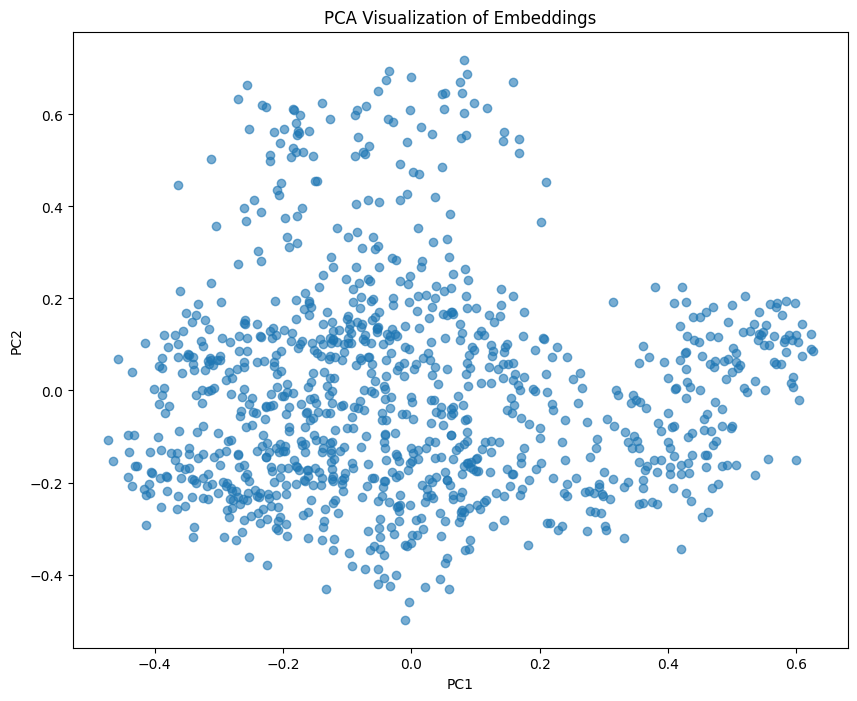

In [80]:
# Creating visualizations of embedding similarities using dimensionality reduction

# Extract embeddings for each chunk from Chroma vector database
data = vs.get(include=['embeddings'])
embeddings = np.array(data['embeddings'])

# Use PCA to reduce dimensionality of embeddings to 2 components
pca = PCA(n_components=2)
coords = pca.fit_transform(embeddings)

# Plot PC1 against PC2
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.6)
plt.title('PCA Visualization of Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [83]:
# Discussion of trade-offs between search accuracy and efficiency
"""
The pros of the regular similarity search method are that it's typically faster on average than MMR as seen in the results produced above and simpler. It also delivers more accurate results than MMR for any query in theory. However, even though MMR is slower, it offers more diverse/less-redundant results and better coverage of the available data/documents. And although the accuracy of the results produced by MMR may not be as accurate as those produced by normal similarity search in theory, the added diversity provided by MMR enables MMR to generate better overall quality results where users can get a better view of all the available data relevant to the search query instead of a more narrow view where only information from a few of the available documents are present in the results.
"""

"\nThe pros of the regular similarity search method are that it's typically faster on average than MMR as seen in the results produced above and simpler. It also delivers more accurate results than MMR for any query in theory. However, even though MMR is slower, it offers more diverse/less-redundant results and better coverage of the available data/documents. And although the accuracy of the results produced by MMR may not be as accurate as those produced by normal similarity search in theory, the added diversity provided by MMR enables MMR to generate better overall quality results where users can get a better view of all the available data relevant to the search query instead of a more narrow view where only information from a few of the available documents are present in the results.\n"

Discussion of trade-offs between search accuracy and efficiency

The pros of the regular similarity search method are that it's typically faster on average than MMR as seen in the results produced above and simpler. It also delivers more accurate results than MMR for any query in theory. However, even though MMR is slower, it offers more diverse/less-redundant results and better coverage of the available data/documents. And although the accuracy of the results produced by MMR may not be as accurate as those produced by normal similarity search in theory, the added diversity provided by MMR enables MMR to generate better overall quality results where users can get a better view of all the available data relevant to the search query instead of a more narrow view where only information from a few of the available documents are present in the results.